# Image classification using CNN

### Set up 

In [88]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix as conf_mat
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.ion()   # interactive mode

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

use_gpu = torch.cuda.is_available()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# function for visualizing images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [4]:
# function to train model 

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloders['train']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


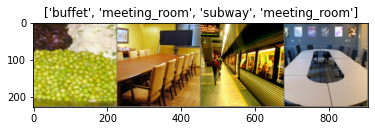

In [6]:
# transform the data 
# augmentation and normalization for train datasets
# normalization for test dataset

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes


# visualize images
# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train the model

#### Finetuning the convnet

Here we take a pretrained model, reset the final fully connected layer, and fine-tune the weights of the pre-trained network using backpropagation. 

Note that when the new dataset is small and similar to the original datset, fine-tuning may lead to overfitting. 

In [12]:
if __name__=='__main__':
    #freeze_support()
    torch.multiprocessing.freeze_support()
     
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)    


Epoch 0/24
----------
train Loss: 1.6776 Acc: 0.4390
test Loss: 0.8795 Acc: 0.6867

Epoch 1/24
----------
train Loss: 1.3008 Acc: 0.5760
test Loss: 1.3333 Acc: 0.5898

Epoch 2/24
----------
train Loss: 1.1340 Acc: 0.6290
test Loss: 1.0813 Acc: 0.6548

Epoch 3/24
----------
train Loss: 1.1269 Acc: 0.6230
test Loss: 1.2893 Acc: 0.6337

Epoch 4/24
----------
train Loss: 0.9878 Acc: 0.6800
test Loss: 0.9044 Acc: 0.7175

Epoch 5/24
----------
train Loss: 0.9469 Acc: 0.6900
test Loss: 1.4295 Acc: 0.6006

Epoch 6/24
----------
train Loss: 0.9488 Acc: 0.7000
test Loss: 1.1736 Acc: 0.6769

Epoch 7/24
----------
train Loss: 0.7184 Acc: 0.7730
test Loss: 0.9800 Acc: 0.7008

Epoch 8/24
----------
train Loss: 0.6175 Acc: 0.8000
test Loss: 0.8579 Acc: 0.7457

Epoch 9/24
----------
train Loss: 0.5172 Acc: 0.8420
test Loss: 0.9423 Acc: 0.7289

Epoch 10/24
----------
train Loss: 0.5606 Acc: 0.8220
test Loss: 0.9678 Acc: 0.7105

Epoch 11/24
----------
train Loss: 0.5029 Acc: 0.8340
test Loss: 0.8677 Acc

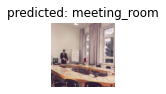

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


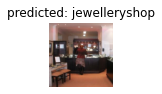

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


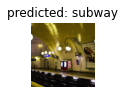

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


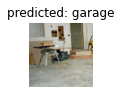

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


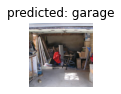

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


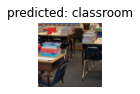

In [13]:
visualize_model(model_ft)

#### Using ConvNet as fixed feature extractor

Here we take a convolutional network that is pre-trained, remove the last fully-connected layer, and use the pre-trained weights to run the classifier.

In [8]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9651 Acc: 0.6640
test Loss: 0.8192 Acc: 0.7170

Epoch 1/24
----------
train Loss: 0.9141 Acc: 0.7010
test Loss: 0.8228 Acc: 0.7116

Epoch 2/24
----------
train Loss: 0.8714 Acc: 0.6980
test Loss: 0.8479 Acc: 0.7089

Epoch 3/24
----------
train Loss: 0.8409 Acc: 0.7160
test Loss: 0.8552 Acc: 0.7056

Epoch 4/24
----------
train Loss: 0.8489 Acc: 0.7130
test Loss: 0.8613 Acc: 0.7062

Epoch 5/24
----------
train Loss: 0.8809 Acc: 0.7120
test Loss: 0.8698 Acc: 0.7002

Epoch 6/24
----------
train Loss: 0.8922 Acc: 0.7070
test Loss: 0.8807 Acc: 0.6991

Epoch 7/24
----------
train Loss: 0.8974 Acc: 0.7110
test Loss: 0.8256 Acc: 0.7165

Epoch 8/24
----------
train Loss: 0.8416 Acc: 0.7130
test Loss: 0.8737 Acc: 0.7067

Epoch 9/24
----------
train Loss: 0.9073 Acc: 0.6950
test Loss: 0.8666 Acc: 0.7056

Epoch 10/24
----------
train Loss: 0.8485 Acc: 0.7170
test Loss: 0.7810 Acc: 0.7224

Epoch 11/24
----------
train Loss: 0.8722 Acc: 0.7240
test Loss: 0.9100 Acc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


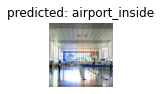

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


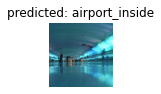

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


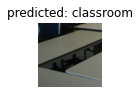

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


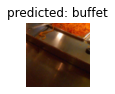

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


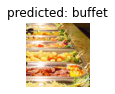

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


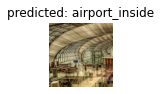

In [14]:
visualize_model(model_conv)

### evaluate model

In [16]:
# get labels and predictions on test data 
model_conv.eval()
predictions=[]
label_data=[]

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloders['test']):
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs=model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        print(inputs.size())
        for j in range(inputs.size()[0]):
            predictions.append(class_names[preds[j]])
            label_data.append(class_names[labels.data[j]])

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4,

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4,

In [75]:
# create confusion matrix and display
cf=conf_mat(label_data, predictions)
cf=pd.DataFrame(cf)
cf


,0,1,2,3,4,5,6,7,8,9
0,429,0,1,4,0,13,7,6,4,44
1,1,75,0,0,4,7,2,1,7,0
2,0,0,11,0,0,0,0,0,0,0
3,0,0,0,13,0,0,0,0,0,0
4,3,4,1,7,96,11,6,5,39,2
5,0,0,0,0,0,3,0,0,0,0
6,2,0,0,0,2,2,48,0,2,1
7,0,0,0,5,1,1,0,114,12,0
8,27,5,8,5,19,7,28,10,299,5
9,108,1,0,0,0,2,5,2,1,320


In [77]:
# print the labels 
labels_dict={i: image_datasets['train'].classes[i] for i in range(len(image_datasets['train'].classes))}

print(labels_dict)

{0: 'airport_inside', 1: 'bathroom', 2: 'buffet', 3: 'classroom', 4: 'dining_room', 5: 'garage', 6: 'jewelleryshop', 7: 'meeting_room', 8: 'restaurant', 9: 'subway'}


In [74]:
# normalize confusion matrix and display
#pd.options.display.float_format = '{:,.2f}'.format
cf_norm=cf.div(cf.sum(axis=1), axis=0)
cf_norm

,0,1,2,3,4,5,6,7,8,9
0,0.84,0.00,0.00,0.01,0.00,0.03,0.01,0.01,0.01,0.09
1,0.01,0.77,0.00,0.00,0.04,0.07,0.02,0.01,0.07,0.00
2,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.02,0.02,0.01,0.04,0.55,0.06,0.03,0.03,0.22,0.01
5,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
6,0.04,0.00,0.00,0.00,0.04,0.04,0.84,0.00,0.04,0.02
7,0.00,0.00,0.00,0.04,0.01,0.01,0.00,0.86,0.09,0.00
8,0.07,0.01,0.02,0.01,0.05,0.02,0.07,0.02,0.72,0.01
9,0.25,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.73


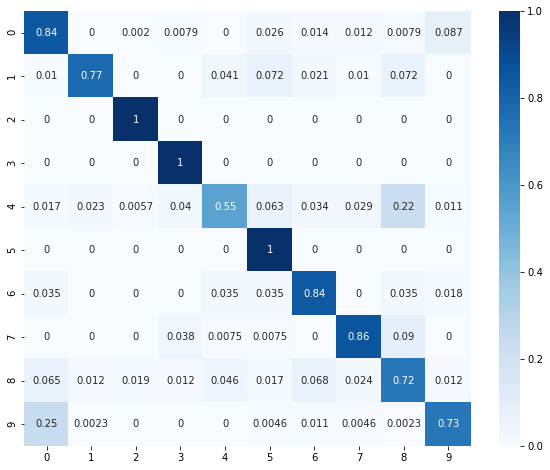

In [87]:
# add heatmap to better visualize
fig, ax = plt.subplots(figsize=(10,8))     

sns.heatmap(cf_norm, cmap="Blues", annot=True, ax=ax)

In [106]:
report = pd.DataFrame(classification_report(label_data, predictions, output_dict=True))[[i for i in image_datasets['train'].classes]].transpose()

report

,precision,recall,f1-score,support
airport_inside,0.75,0.84,0.80,508.00
bathroom,0.88,0.77,0.82,97.00
buffet,0.52,1.00,0.69,11.00
classroom,0.38,1.00,0.55,13.00
dining_room,0.79,0.55,0.65,174.00
garage,0.07,1.00,0.12,3.00
jewelleryshop,0.50,0.84,0.63,57.00
meeting_room,0.83,0.86,0.84,133.00
restaurant,0.82,0.72,0.77,413.00
subway,0.86,0.73,0.79,439.00


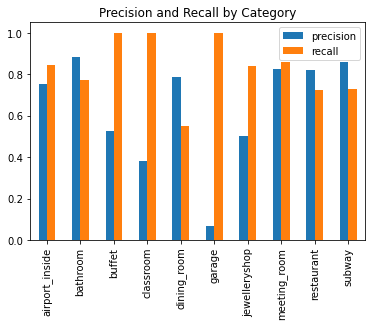

In [119]:
report.plot(y=['precision', 'recall'], kind="bar", title="Precision and Recall by Category")